In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange
from functions import *

#### Compile Stan model:

In [2]:
sm = ps.StanModel(file="model_binaryAR.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_adca34445543ea9daea5f38ba1350097 NOW.


#### Specify parameters:

In [31]:
p = 10
T = 10_000
alph = npr.randn(p)
prob = np.zeros(T)
c = -0.1
q = 5
b = npr.randn(q)

#### Generate and plot covariates:

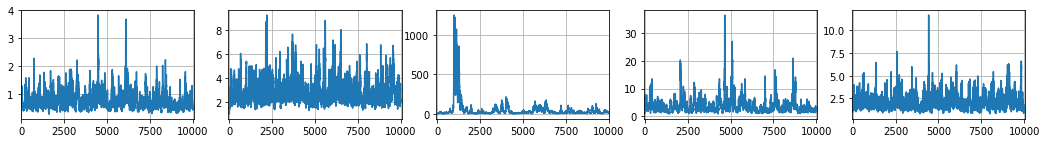

In [50]:
X = generate_X(T, q)

f = plt.figure(figsize=(18,2))
for i in range(q) :
    plt.subplot(1,q,i+1)
    plt.plot(X[:,i])
    plt.xlim(-0.005*T,1.005*T)
    plt.grid(True)

#### Generate and plot observations:

In [51]:
y = np.zeros(T).astype(int)
prob = np.zeros(T)

for t in range(p) :
    prob[t] = 1/(1+np.exp(-(c+X[t].dot(b)))) 
    y[t] = npr.binomial(n=1,p=prob[t],size=1)
for t in np.arange(p+1,T) :
    prob[t] = 1/(1+np.exp(-(c+alph.dot(y[(t-p):t])+X[t].dot(b)))) 
    y[t] = npr.binomial(n=1,p=prob[t],size=1)

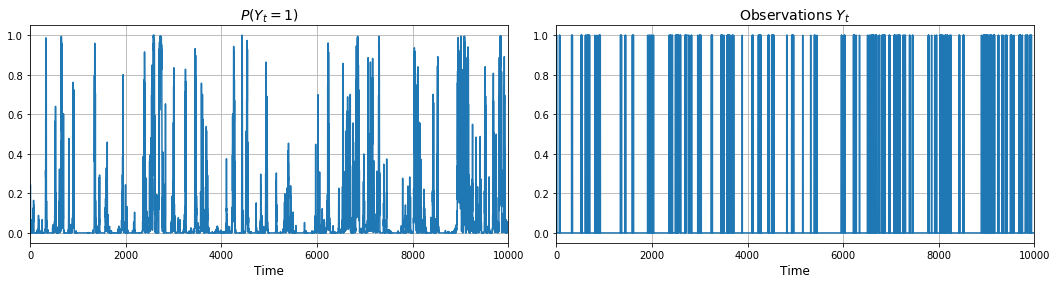

In [72]:
fig = plt.figure(figsize=(18,4))
plt.subplot(121)
plt.plot(prob)
plt.xlim(0,T)
plt.grid(True)
plt.title(r"$P(Y_t=1)$", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.subplot(122)
plt.plot(y)
plt.xlim(0,T)
plt.grid(True)
plt.title(r"Observations $Y_t$", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.subplots_adjust(wspace=1e-1)

fig.savefig('binary_AR_data.pdf', bbox_inches='tight', dpi=500)

#### Save data in file:

In [53]:
dat = dict(y=y, X=X, prob=prob, alpha=alph, b=b, c=c)
file = open("/xtmp/DC-BATS_data/binary_AR/data.pkl", "wb")
pickle.dump(dat, file)
file.close()

In [54]:
print(np.mean(prob))
print([np.mean(y[i*1000:(i+1)*1000]) for i in range(10)])

0.07862465797926224
[0.066, 0.031, 0.139, 0.054, 0.083, 0.019, 0.109, 0.056, 0.104, 0.146]


### MCMC on full dataset:

In [55]:
n_chains = 10

tstart, tend = 0, T
data = dict(T=tend-tstart, p=p, q=q, y=y[tstart:tend], X=X[tstart:tend,:], power=1)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
mle = sm.optimizing(data=data)
print(round((time()-start)/60,2), "minutes to run")
trace = fit.extract()

file = open("/xtmp/DC-BATS_data/binary_AR/full_mcmc.pkl", "wb")
pickle.dump(trace, file)
file.close()
file = open("/xtmp/DC-BATS_data/binary_AR/full_mle.pkl", "wb")
pickle.dump(mle, file)
file.close()

12.24 minutes to run


### Divide-and-conquer

In [66]:
m = 10
tstarts = np.arange(m).astype(int)
tends = 1 + tstarts
tstarts *= int(T/m)
tends *= int(T/m)

In [ ]:
for i in range(m) :
    tstart, tend = tstarts[i], tends[i]
    data = dict(T=tend-tstart, p=p, q=q, y=y[tstart:tend], X=X[tstart:tend,:], power=T/(tend-tstart))
    fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
    trace = fit.extract()
    file = open("/xtmp/DC-BATS_data/binary_AR/mcmc_wb_chunk"+str(i+1)+".pkl", "wb")
    pickle.dump(trace, file)
    file.close()
    mle = sm.optimizing(data=data)
    file = open("/xtmp/DC-BATS_data/binary_AR/mle_chunk"+str(i+1)+".pkl", "wb")
    pickle.dump(mle, file)
    file.close()